# Meteorite Impacts

NASA has helpfully provided a dataset which lists recorded meteorite impacts - get it in `"Meteorite_Landings.csv"`. Can we utilise this dataset to predict the chance that, within 1000 years, a high-impact meteor will strike the planet?

Let's define high-impact as an asteroid greater than 1km in diameter. 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("Meteorite_Landings.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45716 entries, 0 to 45715
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   name         45716 non-null  object 
 1   id           45716 non-null  int64  
 2   nametype     45716 non-null  object 
 3   recclass     45716 non-null  object 
 4   mass         45585 non-null  float64
 5   fall         45716 non-null  object 
 6   year         45428 non-null  float64
 7   reclat       38401 non-null  float64
 8   reclong      38401 non-null  float64
 9   GeoLocation  38401 non-null  object 
dtypes: float64(4), int64(1), object(5)
memory usage: 3.5+ MB


In [3]:
df.head()

,name,id,nametype,recclass,mass,fall,year,reclat,reclong,GeoLocation
0,Aachen,1,Valid,L5,21.0,Fell,1880.0,50.77500,6.08333,"(50.775000, 6.083330)"
1,Aarhus,2,Valid,H6,720.0,Fell,1951.0,56.18333,10.23333,"(56.183330, 10.233330)"
2,Abee,6,Valid,EH4,107000.0,Fell,1952.0,54.21667,-113.00000,"(54.216670, -113.000000)"
3,Acapulco,10,Valid,Acapulcoite,1914.0,Fell,1976.0,16.88333,-99.90000,"(16.883330, -99.900000)"
4,Achiras,370,Valid,L6,780.0,Fell,1902.0,-33.16667,-64.95000,"(-33.166670, -64.950000)"


In [6]:
# Remove rows with null values in mass and year, since they're useless
df2 = df.dropna(subset=["mass", "year"])
# A mass of 0 makes no sense....
df2 = df2[df2["mass"] > 0]

In [7]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45292 entries, 0 to 45715
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   name         45292 non-null  object 
 1   id           45292 non-null  int64  
 2   nametype     45292 non-null  object 
 3   recclass     45292 non-null  object 
 4   mass         45292 non-null  float64
 5   fall         45292 non-null  object 
 6   year         45292 non-null  float64
 7   reclat       38097 non-null  float64
 8   reclong      38097 non-null  float64
 9   GeoLocation  38097 non-null  object 
dtypes: float64(4), int64(1), object(5)
memory usage: 3.8+ MB


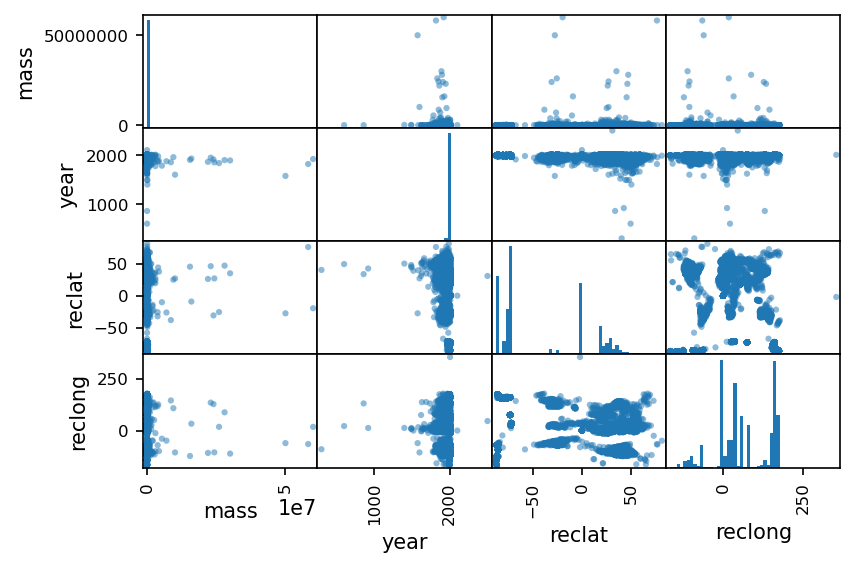

In [11]:
plt.rcParams['figure.dpi'] = 150
pd.plotting.scatter_matrix(df[["mass", "year", "reclat", "reclong"]], hist_kwds={'bins':50});

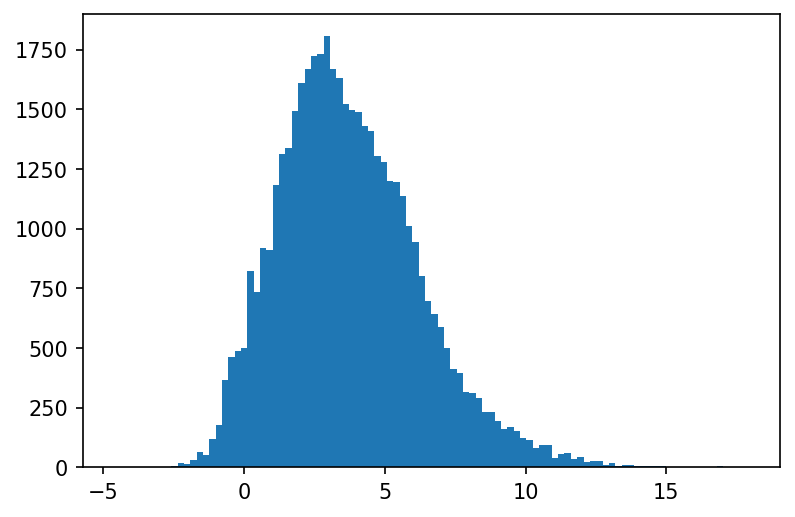

In [13]:
# Data is extremely skewed
year = df2["year"]
mass = df2["mass"]
# Due to skewness, work in log space
logmass = np.log(mass)

plt.hist(logmass, bins=100);
# Suddenly looks like a nice distribution that you can work with :)

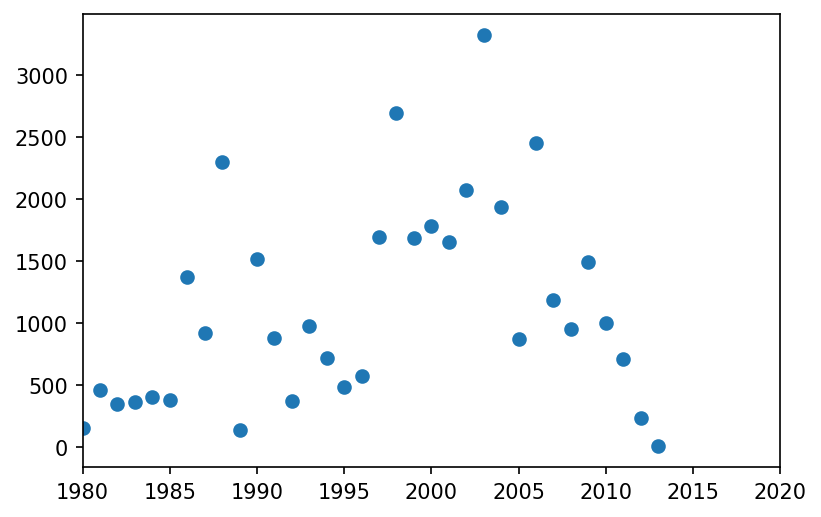

In [15]:
counts = year.value_counts()
plt.scatter(counts.index, counts) # counts.index -> the actual year
plt.xlim(1980, 2020);

# Cut the data at 2008/9 and ignore data after that
# The cutoff in data is because multiple sources were compiled to get this data
# Different sources end at different times...
# Easier to look at the worst case scenario -> assume every year has the same impact rate as ~2004,
# what would the probability be?
# Difficult to do otherwise because:
# 1.) the fall in data is not asteroid related but due to how the sources recorded the data
# 2.) The apparent upwards trend before the cutoff is likely to be related to better technology used to record/find them
# These are impossible to characterise and account for..
# Ignore the year, there is no way that asteroid impacts and the year are correlated...

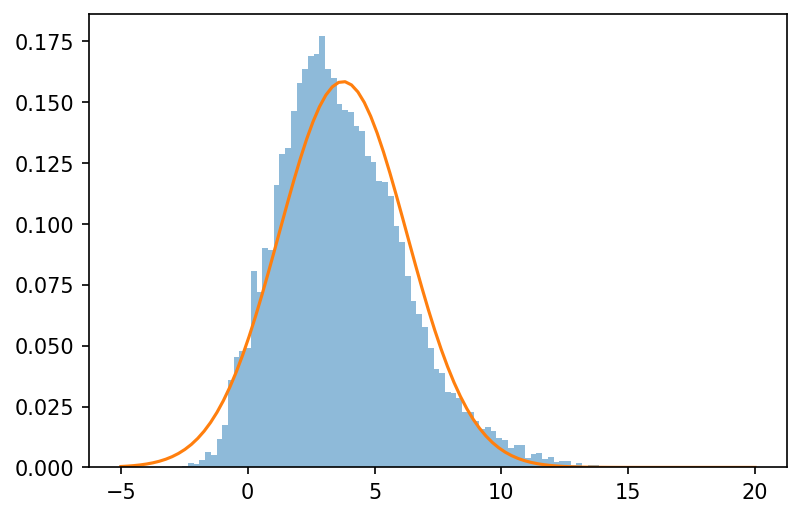

In [16]:
from scipy.stats import norm, skewnorm, lognorm
ms = np.linspace(-5, 20, 100) # log-values to sample on

mean, std = logmass.mean(), np.std(logmass)
pdf_norm = norm.pdf(ms, mean, std)
plt.hist(logmass, bins=100, density=True, alpha=0.5)
plt.plot(ms, pdf_norm);
# Not the best fit...

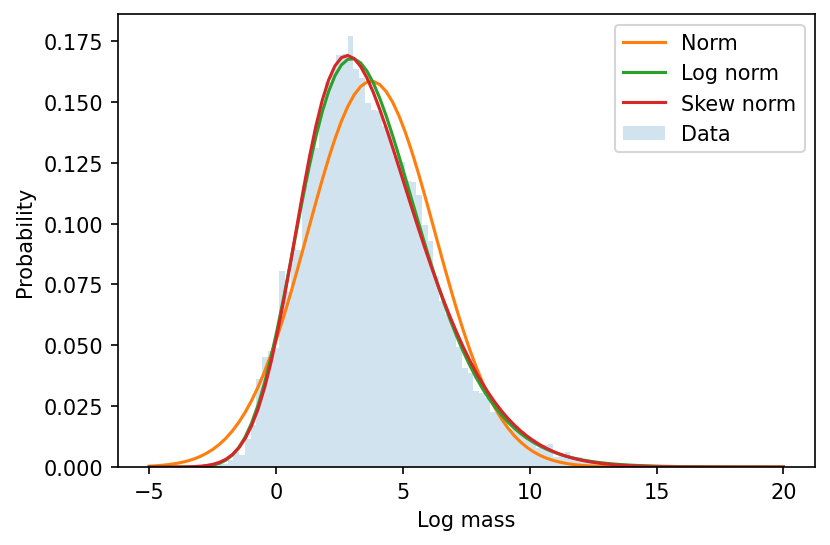

In [17]:
p_lognorm = lognorm.fit(logmass)
pdf_lognorm = lognorm.pdf(ms, *p_lognorm) # *p_lognorm expands the fitted parameters (mean and std)
p_skewnorm = skewnorm.fit(logmass)
pdf_skewnorm = skewnorm.pdf(ms, *p_skewnorm)

plt.hist(logmass, bins=100, density=True, alpha=0.2, label="Data")
plt.plot(ms, pdf_norm, label="Norm")
plt.plot(ms, pdf_lognorm, label="Log norm")
plt.plot(ms, pdf_skewnorm, label="Skew norm");
plt.legend()
plt.xlabel("Log mass")
plt.ylabel("Probability");
# Skewnorm and lognorm are much better, since the data is physically motivated we will use lognorm
# If the data wasn't physically motivated, you'd use both and see which gives you the better answer
# Impossible to tell by the eye which is better (in this case)

In [18]:
# Get a log value for the mass of an asteroid that is 1km long
# Volume of a sphere multiplied by the average density of an asteroid
mass_of_doom = np.log((4/3) * np.pi * 500**3 * 1600 * 1000)  # Simple approximation
mass_of_doom
# We will run with this number because it's the best that we have
# You usualky wouldn't and would try to change your approach/question/etc..
# Because extrapolating is dangerous...

34.36175044077777

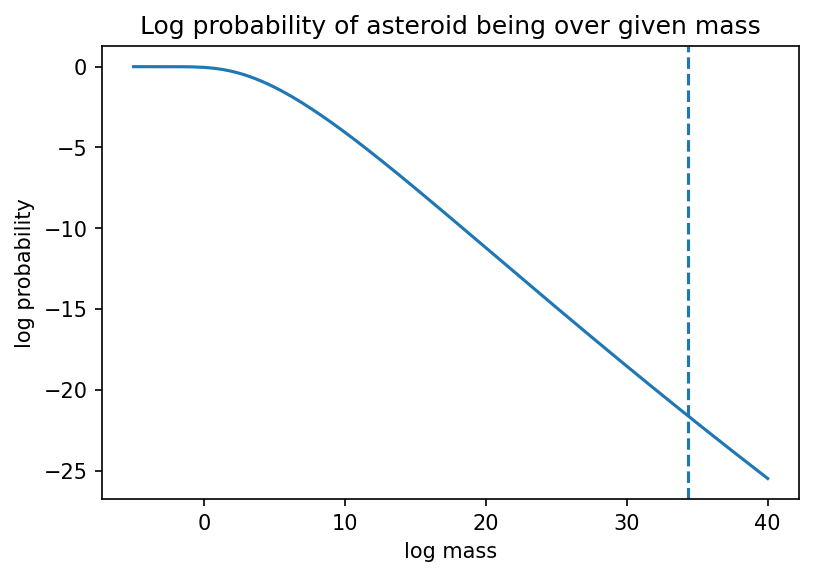

In [19]:
ms2 = np.linspace(-5, 40, 200) # New logmass area that encompasses our mass_of_doom
# Sampling the log survival function (.logsf()) at ms2 points, given the parametrization of the log-normal distribution
plt.plot(ms2, lognorm.logsf(ms2, *p_lognorm))
plt.axvline(mass_of_doom, ls="--")
plt.xlabel("log mass")
plt.ylabel("log probability")
plt.title("Log probability of asteroid being over given mass");
# Extremely low probability

So we have here the probability of an asteroid being above a certain mass when it hits Earth. But to answer the question "What is the probability that one or more asteroids of high mass strike Earth in 1000 years?" we need to factor in the actual time component. Assume that in the next 1000 years, we predict to have $N$ impacts.

$$P(>=1\  {\rm highmass}) = 1 - P(0\ {\rm highmass}) = 1 - P(N\ {\rm not\_highmass}) = 1 - P({\rm not\_highmass})^N$$

Raising to the power of N because each event is independent.

Imagine a similar question: Prob of getting no sixes in 5 rolls. Well its $$\frac{5}{6}\times\frac{5}{6}\times\frac{5}{6}\times\frac{5}{6}\times\frac{5}{6} = \left(\frac{5}{6}\right)^5 $$
The prob of getting one or more sixes is then $1 - (5/6)^5$.

So to give a number, we need to calculate $N$ from the yearly rate, number of years, and our detection efficiency and use that with the probability that any given impact is not high mass.

In [22]:
# We do not know N (the rate), we could take the mean of the best and worst case scenarion and take 2 stds
# But it's not simple
# For now, make a simple assumption
# Looking at the geolocation data in the scatter matrix, only meteorites recorded are the ones that fall on land
# But meteorites also fall in in the oceans... we can correct for this by assuming we only record 20% of the events

prob_small_mass = lognorm.logcdf(mass_of_doom, *p_lognorm) # 1-SF, so everything under the mass_of_doom
# expect a almost certain prob. -> print(np.exp(prob_small_mass)) = 0.9999999995938732
frac_sky_monitored = 0.2 # Fraction of the sky monitored assumed to be 20%
num_years = 1000
# worst case scenario -> the worst year (counts.max()) for a 1000 years
# If only 20% of the sky is monitored, then we have 5 times as many events (correcting for unmonitored)
num_events = num_years * counts.max() / frac_sky_monitored
# print(num_events) = 1661000.0
prob_bad = 1 - np.exp(num_events * prob_small_mass)
print(f"Prob a >1km asteroid impacts with {num_years} years is {prob_bad * 100:.2f}%")

Prob a >1km asteroid impacts with 1000 years is 0.67%


In [ ]:
# This was effectively a one-tailed test